# Bike Sharing Demand Prediction

# Import Libraries and Setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr, shapiro, normaltest, anderson
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import zipfile
import os
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Data Loading and Initial Setup

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
zip_path = "Bike-Sharing-Dataset.zip"
extracted_path = "Bike-Sharing-Dataset"

if not os.path.exists(zip_path):
    import requests
    r = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

df_day = pd.read_csv(os.path.join(extracted_path, 'day.csv'))

print(f"Dataset loaded with shape: {df_day.shape}")
print(f"Features: {list(df_day.columns)}")
print(f"Target variable statistics:")
print(df_day['cnt'].describe())

Dataset loaded with shape: (731, 16)
Features: ['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
Target variable statistics:
count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64


# Data Exploration

In [10]:
print("=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {df_day.shape}")
print(f"Memory Usage: {df_day.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Data Types:\n{df_day.dtypes}")
print(f"\n=== MISSING VALUES ===")
print(df_day.isnull().sum())
print(f"\n=== DUPLICATE ROWS ===")
print(f"Number of duplicates: {df_day.duplicated().sum()}")
print(f"\n=== BASIC STATISTICS ===")
print(df_day.describe())
print(f"\n=== CATEGORICAL VARIABLES DISTRIBUTION ===")
categorical_cols = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'holiday', 'weathersit']
for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(df_day[col].value_counts().sort_index())
print(f"\n=== TARGET VARIABLE ANALYSIS ===")
print(f"Count Range: {df_day['cnt'].min()} - {df_day['cnt'].max()}")
print(f"Count Mean: {df_day['cnt'].mean():.2f}")
print(f"Count Std: {df_day['cnt'].std():.2f}")
print(f"Count Skewness: {df_day['cnt'].skew():.3f}")
print(f"Count Kurtosis: {df_day['cnt'].kurtosis():.3f}")

=== DATASET OVERVIEW ===
Dataset Shape: (731, 16)
Memory Usage: 0.13 MB
Data Types:
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

=== MISSING VALUES ===
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

=== DUPLICATE ROWS ===
Number of duplicates: 0

=== BASIC STATISTICS ===
          instant      season          yr        mnth     holiday     weekday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean   366.000000    

# Visualization Dashboard

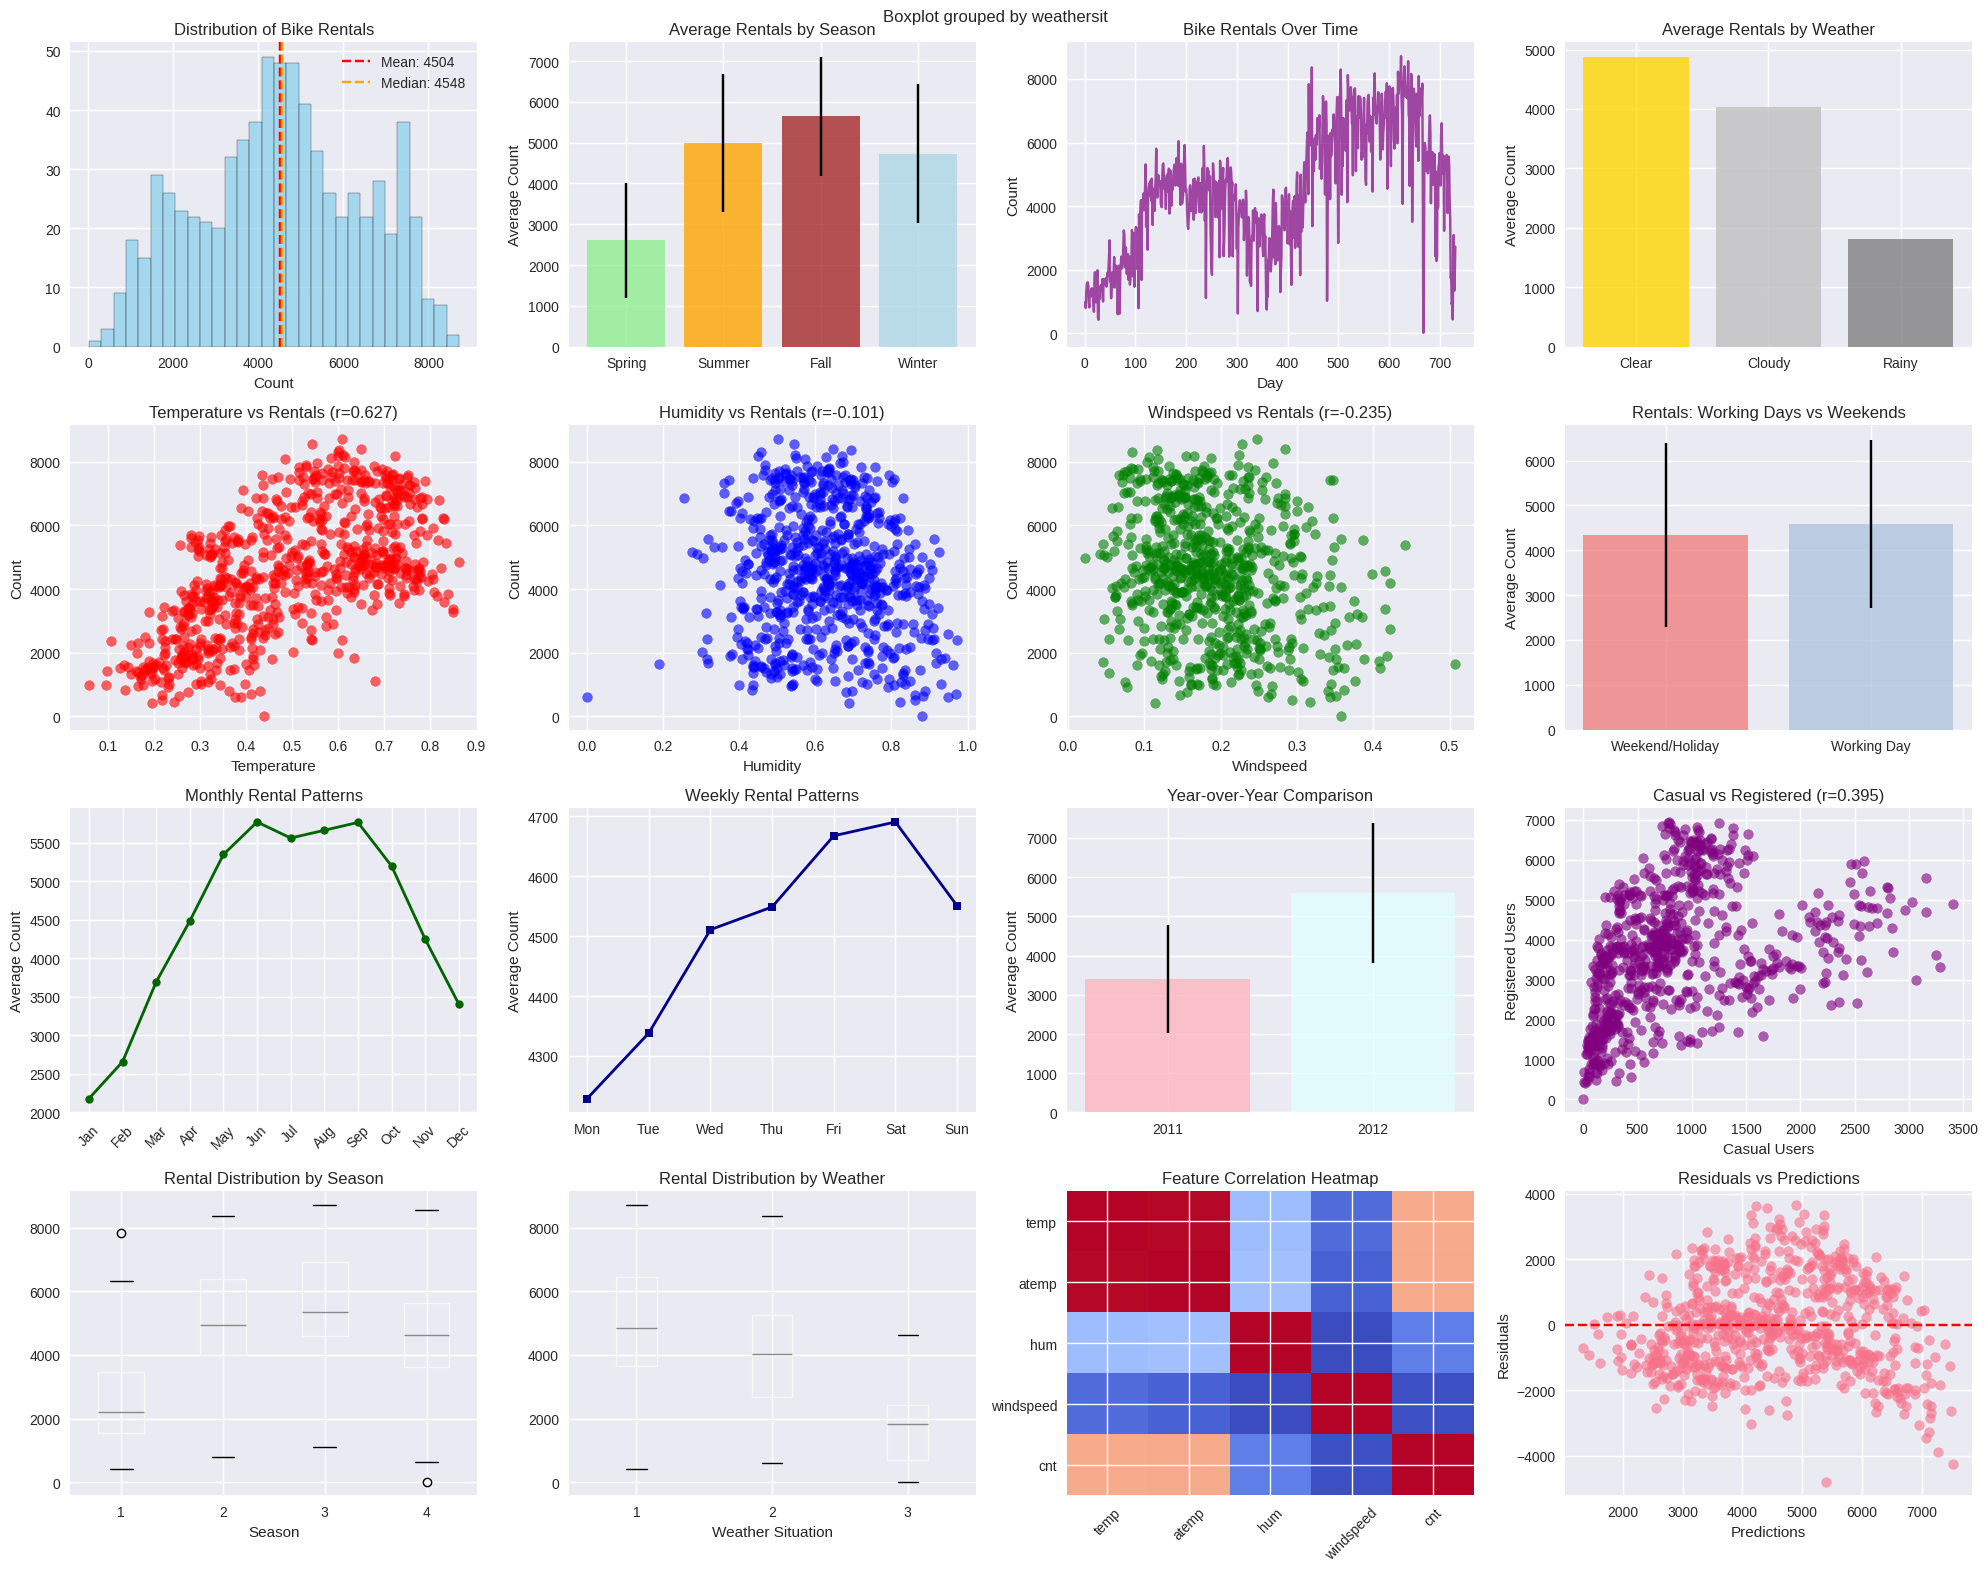

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Comprehensive Bike Sharing Analysis Dashboard', fontsize=20, fontweight='bold')

axes[0,0].hist(df_day['cnt'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df_day['cnt'].mean(), color='red', linestyle='--', label=f'Mean: {df_day["cnt"].mean():.0f}')
axes[0,0].axvline(df_day['cnt'].median(), color='orange', linestyle='--', label=f'Median: {df_day["cnt"].median():.0f}')
axes[0,0].set_title('Distribution of Bike Rentals')
axes[0,0].set_xlabel('Count')
axes[0,0].legend()

seasonal_data = df_day.groupby('season')['cnt'].agg(['mean', 'std', 'count'])
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
axes[0,1].bar(seasons, seasonal_data['mean'], yerr=seasonal_data['std'],
              capsize=10, color=['lightgreen', 'orange', 'brown', 'lightblue'], alpha=0.8)
axes[0,1].set_title('Average Rentals by Season')
axes[0,1].set_ylabel('Average Count')

axes[0,2].plot(df_day['instant'], df_day['cnt'], alpha=0.7, color='purple')
axes[0,2].set_title('Bike Rentals Over Time')
axes[0,2].set_xlabel('Day')
axes[0,2].set_ylabel('Count')

weather_labels = ['Clear', 'Cloudy', 'Rainy']
weather_data = df_day.groupby('weathersit')['cnt'].mean()
colors = ['gold', 'silver', 'gray']
axes[0,3].bar(weather_labels, weather_data, color=colors, alpha=0.8)
axes[0,3].set_title('Average Rentals by Weather')
axes[0,3].set_ylabel('Average Count')

axes[1,0].scatter(df_day['temp'], df_day['cnt'], alpha=0.6, color='red')
correlation = df_day['temp'].corr(df_day['cnt'])
axes[1,0].set_title(f'Temperature vs Rentals (r={correlation:.3f})')
axes[1,0].set_xlabel('Temperature')
axes[1,0].set_ylabel('Count')

axes[1,1].scatter(df_day['hum'], df_day['cnt'], alpha=0.6, color='blue')
correlation = df_day['hum'].corr(df_day['cnt'])
axes[1,1].set_title(f'Humidity vs Rentals (r={correlation:.3f})')
axes[1,1].set_xlabel('Humidity')
axes[1,1].set_ylabel('Count')

axes[1,2].scatter(df_day['windspeed'], df_day['cnt'], alpha=0.6, color='green')
correlation = df_day['windspeed'].corr(df_day['cnt'])
axes[1,2].set_title(f'Windspeed vs Rentals (r={correlation:.3f})')
axes[1,2].set_xlabel('Windspeed')
axes[1,2].set_ylabel('Count')

workday_data = df_day.groupby('workingday')['cnt'].agg(['mean', 'std'])
labels = ['Weekend/Holiday', 'Working Day']
axes[1,3].bar(labels, workday_data['mean'], yerr=workday_data['std'],
              capsize=10, color=['lightcoral', 'lightsteelblue'], alpha=0.8)
axes[1,3].set_title('Rentals: Working Days vs Weekends')
axes[1,3].set_ylabel('Average Count')

monthly_data = df_day.groupby('mnth')['cnt'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2,0].plot(months, monthly_data, marker='o', linewidth=2, markersize=6, color='darkgreen')
axes[2,0].set_title('Monthly Rental Patterns')
axes[2,0].set_ylabel('Average Count')
axes[2,0].tick_params(axis='x', rotation=45)

weekly_data = df_day.groupby('weekday')['cnt'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[2,1].plot(days, weekly_data, marker='s', linewidth=2, markersize=6, color='darkblue')
axes[2,1].set_title('Weekly Rental Patterns')
axes[2,1].set_ylabel('Average Count')

yearly_data = df_day.groupby('yr')['cnt'].agg(['mean', 'std', 'count'])
years = ['2011', '2012']
axes[2,2].bar(years, yearly_data['mean'], yerr=yearly_data['std'],
              capsize=10, color=['lightpink', 'lightcyan'], alpha=0.8)
axes[2,2].set_title('Year-over-Year Comparison')
axes[2,2].set_ylabel('Average Count')

axes[2,3].scatter(df_day['casual'], df_day['registered'], alpha=0.6, color='purple')
correlation = df_day['casual'].corr(df_day['registered'])
axes[2,3].set_title(f'Casual vs Registered (r={correlation:.3f})')
axes[2,3].set_xlabel('Casual Users')
axes[2,3].set_ylabel('Registered Users')

df_day.boxplot(column='cnt', by='season', ax=axes[3,0])
axes[3,0].set_title('Rental Distribution by Season')
axes[3,0].set_xlabel('Season')

df_day.boxplot(column='cnt', by='weathersit', ax=axes[3,1])
axes[3,1].set_title('Rental Distribution by Weather')
axes[3,1].set_xlabel('Weather Situation')

numeric_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
corr_matrix = df_day[numeric_cols].corr()
im = axes[3,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
axes[3,2].set_xticks(range(len(numeric_cols)))
axes[3,2].set_yticks(range(len(numeric_cols)))
axes[3,2].set_xticklabels(numeric_cols, rotation=45)
axes[3,2].set_yticklabels(numeric_cols)
axes[3,2].set_title('Feature Correlation Heatmap')

from sklearn.linear_model import LinearRegression
X_simple = df_day[['temp', 'hum', 'windspeed']].values
y_simple = df_day['cnt'].values
lr = LinearRegression().fit(X_simple, y_simple)
predictions = lr.predict(X_simple)
residuals = y_simple - predictions
axes[3,3].scatter(predictions, residuals, alpha=0.6)
axes[3,3].axhline(y=0, color='red', linestyle='--')
axes[3,3].set_title('Residuals vs Predictions')
axes[3,3].set_xlabel('Predictions')
axes[3,3].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# Statistical Analysis and Feature Engineering

In [12]:
print("=== STATISTICAL TESTS AND FEATURE ENGINEERING ===")

continuous_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
print("NORMALITY TESTS:")
for var in continuous_vars:
    shapiro_stat, shapiro_p = shapiro(df_day[var])
    dagostino_stat, dagostino_p = normaltest(df_day[var])
    print(f"{var}: Shapiro-Wilk p={shapiro_p:.4f}, D'Agostino p={dagostino_p:.4f}")

df_enhanced = df_day.copy()

df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['mnth'] / 12)
df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['mnth'] / 12)
df_enhanced['weekday_sin'] = np.sin(2 * np.pi * df_enhanced['weekday'] / 7)
df_enhanced['weekday_cos'] = np.cos(2 * np.pi * df_enhanced['weekday'] / 7)

df_enhanced['temp_squared'] = df_enhanced['temp'] ** 2
df_enhanced['temp_cubed'] = df_enhanced['temp'] ** 3
df_enhanced['feels_like_diff'] = df_enhanced['atemp'] - df_enhanced['temp']

df_enhanced['temp_hum_interaction'] = df_enhanced['temp'] * df_enhanced['hum']
df_enhanced['temp_wind_interaction'] = df_enhanced['temp'] * df_enhanced['windspeed']
df_enhanced['weather_severity'] = df_enhanced['weathersit'] * df_enhanced['hum'] * df_enhanced['windspeed']

df_enhanced['is_summer'] = (df_enhanced['season'] == 2).astype(int)
df_enhanced['is_fall'] = (df_enhanced['season'] == 3).astype(int)
df_enhanced['is_winter'] = (df_enhanced['season'] == 4).astype(int)

df_enhanced['days_since_start'] = df_enhanced['instant']
df_enhanced['year_progress'] = (df_enhanced['instant'] % 365) / 365

df_enhanced['temp_bin'] = pd.cut(df_enhanced['temp'], bins=5, labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])
df_enhanced['hum_bin'] = pd.cut(df_enhanced['hum'], bins=3, labels=['Low', 'Medium', 'High'])

df_enhanced['weekend'] = (df_enhanced['weekday'].isin([5, 6])).astype(int)
df_enhanced['holiday_weekend'] = df_enhanced['holiday'] * df_enhanced['weekend']

print(f"\nOriginal features: {df_day.shape[1]}")
print(f"Enhanced features: {df_enhanced.shape[1]}")
print(f"New features created: {df_enhanced.shape[1] - df_day.shape[1]}")

new_features = ['month_sin', 'month_cos', 'temp_squared', 'temp_hum_interaction',
                'feels_like_diff', 'weather_severity', 'year_progress']
print(f"\nCORRELATION OF NEW FEATURES WITH TARGET:")
for feature in new_features:
    corr = df_enhanced[feature].corr(df_enhanced['cnt'])
    print(f"{feature}: {corr:.4f}")

=== STATISTICAL TESTS AND FEATURE ENGINEERING ===
NORMALITY TESTS:
temp: Shapiro-Wilk p=0.0000, D'Agostino p=0.0000
atemp: Shapiro-Wilk p=0.0000, D'Agostino p=0.0000
hum: Shapiro-Wilk p=0.0025, D'Agostino p=0.7105
windspeed: Shapiro-Wilk p=0.0000, D'Agostino p=0.0000
cnt: Shapiro-Wilk p=0.0000, D'Agostino p=0.0000

Original features: 16
Enhanced features: 35
New features created: 19

CORRELATION OF NEW FEATURES WITH TARGET:
month_sin: -0.3895
month_cos: -0.4504
temp_squared: 0.5762
temp_hum_interaction: 0.4503
feels_like_diff: -0.4011
weather_severity: -0.3465
year_progress: 0.2933


# Advanced Data Preprocessing Pipeline

In [14]:
print("=== ADVANCED PREPROCESSING PIPELINE ===")

temporal_features = ['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'year_progress']
weather_features = ['temp', 'atemp', 'hum', 'windspeed', 'temp_squared', 'temp_cubed']
interaction_features = ['temp_hum_interaction', 'temp_wind_interaction', 'weather_severity']
categorical_features = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'holiday', 'weathersit']
binary_features = ['is_summer', 'is_fall', 'is_winter', 'weekend', 'holiday_weekend']

features_to_drop = ['instant', 'casual', 'registered', 'temp_bin', 'hum_bin']
df_model = df_enhanced.drop(columns=features_to_drop + ['cnt'])

y = df_enhanced['cnt'].values
preprocessing_strategies = {}

scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(df_model.select_dtypes(include=[np.number]))
preprocessing_strategies['standard'] = (X_standard, scaler_standard)

scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(df_model.select_dtypes(include=[np.number]))
preprocessing_strategies['minmax'] = (X_minmax, scaler_minmax)

scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(df_model.select_dtypes(include=[np.number]))
preprocessing_strategies['robust'] = (X_robust, scaler_robust)

power_transformer = PowerTransformer(method='yeo-johnson')
X_power = power_transformer.fit_transform(df_model.select_dtypes(include=[np.number]))
preprocessing_strategies['power'] = (X_power, power_transformer)

quantile_transformer = QuantileTransformer(output_distribution='normal')
X_quantile = quantile_transformer.fit_transform(df_model.select_dtypes(include=[np.number]))
preprocessing_strategies['quantile'] = (X_quantile, quantile_transformer)

target_strategies = {}
target_strategies['original'] = y
y_log = np.log1p(y)
target_strategies['log'] = y_log

y_sqrt = np.sqrt(y)
target_strategies['sqrt'] = y_sqrt

y_boxcox = (y**0.5 - 1) / 0.5
target_strategies['boxcox'] = y_boxcox

print(f"Created {len(preprocessing_strategies)} preprocessing strategies")
print(f"Created {len(target_strategies)} target transformation strategies")
print(f"Feature matrix shape: {X_standard.shape}")

print(f"\nPREPROCESSING IMPACT ANALYSIS:")
for name, (X_transformed, transformer) in preprocessing_strategies.items():
    print(f"\n{name.upper()} SCALING:")
    print(f"  Mean: {X_transformed.mean():.4f}")
    print(f"  Std: {X_transformed.std():.4f}")
    print(f"  Min: {X_transformed.min():.4f}")
    print(f"  Max: {X_transformed.max():.4f}")

print(f"\nTARGET TRANSFORMATION ANALYSIS:")
for name, y_transformed in target_strategies.items():
    print(f"{name.upper()}: Mean={y_transformed.mean():.2f}, Std={y_transformed.std():.2f}, Skew={pd.Series(y_transformed).skew():.3f}")

=== ADVANCED PREPROCESSING PIPELINE ===
Created 5 preprocessing strategies
Created 4 target transformation strategies
Feature matrix shape: (731, 28)

PREPROCESSING IMPACT ANALYSIS:

STANDARD SCALING:
  Mean: -0.0000
  Std: 1.0000
  Min: -15.3518
  Max: 19.0919

MINMAX SCALING:
  Mean: 0.4123
  Std: 0.3658
  Min: 0.0000
  Max: 1.0000

ROBUST SCALING:
  Mean: 0.0303
  Std: 0.6412
  Min: -12.3567
  Max: 7.0541

POWER SCALING:
  Mean: 0.0000
  Std: 1.0000
  Min: -4.4260
  Max: 19.0919

QUANTILE SCALING:
  Mean: -0.7725
  Std: 3.1968
  Min: -5.1993
  Max: 5.1993

TARGET TRANSFORMATION ANALYSIS:
ORIGINAL: Mean=4504.35, Std=1935.89, Skew=-0.047
LOG: Mean=8.28, Std=0.58, Skew=-1.908
SQRT: Mean=65.24, Std=15.75, Skew=-0.576
BOXCOX: Mean=128.48, Std=31.49, Skew=-0.576


# Model Selection and Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("=== COMPREHENSIVE MODEL SELECTION ===")

models_config = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': uniform(0.01, 10),
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': uniform(0.01, 2),
            'max_iter': randint(1000, 5000)
        }
    },
    'elastic_net': {
        'model': ElasticNet(),
        'params': {
            'alpha': uniform(0.01, 2),
            'l1_ratio': uniform(0.1, 0.9),
            'max_iter': randint(1000, 5000)
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': randint(3, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['auto', 'sqrt', 'log2', None],
            'criterion': ['squared_error', 'absolute_error']
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 200),
            'max_depth': randint(5, 25),
            'min_samples_split': randint(2, 15),
            'min_samples_leaf': randint(1, 8),
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 12),
            'subsample': uniform(0.6, 0.4),
            'min_samples_split': randint(2, 15),
            'min_samples_leaf': randint(1, 8)
        }
    },
    'ada_boost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 2),
            'loss': ['linear', 'square', 'exponential']
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'C': uniform(0.1, 10),
            'epsilon': uniform(0.01, 0.5),
            'kernel': ['rbf', 'linear', 'poly'],
            'gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(3))
        }
    },
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': randint(3, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    'mlp': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'lbfgs'],
            'alpha': uniform(0.0001, 0.01),
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [1000, 2000, 3000]
        }
    }
}

X_train, X_test, y_train, y_test = train_test_split(
    X_standard, y, test_size=0.2, random_state=42, stratify=None
)

best_models = {}
model_scores = {}

print("Optimizing models with RandomizedSearchCV...")
for model_name, config in models_config.items():
    print(f"\nOptimizing {model_name}...")

    if config['params']:
        search = RandomizedSearchCV(
            config['model'],
            config['params'],
            n_iter=50,
            cv=5,
            scoring='r2',
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_models[model_name] = search.best_estimator_
        model_scores[model_name] = search.best_score_
        print(f"  Best CV Score: {search.best_score_:.4f}")
        print(f"  Best Params: {search.best_params_}")
    else:
        config['model'].fit(X_train, y_train)
        cv_scores = cross_val_score(config['model'], X_train, y_train, cv=5, scoring='r2')
        best_models[model_name] = config['model']
        model_scores[model_name] = cv_scores.mean()
        print(f"  CV Score: {cv_scores.mean():.4f}")

sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nMODEL RANKING BY CV SCORE:")
for i, (model_name, score) in enumerate(sorted_models, 1):
    print(f"{i:2d}. {model_name:<20}: {score:.4f}")

=== COMPREHENSIVE MODEL SELECTION ===
Optimizing models with RandomizedSearchCV...

Optimizing linear_regression...
  CV Score: 0.8565

Optimizing ridge...
  Best CV Score: 0.8520
  Best Params: {'alpha': np.float64(0.16966252220214195), 'solver': 'svd'}

Optimizing lasso...
  Best CV Score: 0.8570
  Best Params: {'alpha': np.float64(0.340533878126005), 'max_iter': 4928}

Optimizing elastic_net...
  Best CV Score: 0.8453
  Best Params: {'alpha': np.float64(0.051168988591604896), 'l1_ratio': np.float64(0.9729188669457949), 'max_iter': 2515}

Optimizing decision_tree...
  Best CV Score: 0.7993
  Best Params: {'criterion': 'absolute_error', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 13}

Optimizing random_forest...
  Best CV Score: 0.8735
  Best Params: {'bootstrap': False, 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}

Optimizing gradient_boosting...
  Best CV Score: 0.8906
  Best Param